# Augmentations

`AudibleLight` supports two kinds of augmentations, which each apply to different objects:

1) `EventAugmentation` objects are applied to `Event` objects, prior to spatializing these.
    - Typically, these manipulate some aspect of the underlying audio file used by the `Event`, such as by applying equalization, fade-ins or fade-outs, or distortion.
2) `SceneAugmentation` objects are applied to an entire `Scene`, after spatializing the audio
    - These augmentations manipulate the *entire* spatial audio, perhaps by masking particular frequency bands or time spans.

`AudibleLight` provides many `Event` and `Scene` augmentations inside `audiblelight.augmentations`, that should be usable in many different circumstances. But if you want to define your own augmentation, you can also subclass either `EventAugmentation` or `SceneAugmentation` and provide your own logic.

## Event Augmentations

Augmentations can be added to `Event` objects in a number of ways.

### Add augmentations when creating an `Event`

The simplest way is to provide a list of `EventAugmentation` classes or instances to `Scene.add_event`, as follows:

In [1]:
# Import dependencies
from audiblelight import utils
from audiblelight.augmentation import Phaser, Distortion, Delay, EventAugmentation
from audiblelight.core import Scene

In [2]:
# Create a Scene object
sc = Scene(
    duration=50,
    mesh_path=utils.get_project_root() / "tests/test_resources/meshes/Oyens.glb",
    fg_path=utils.get_project_root() / "tests/test_resources/soundevents",
    max_overlap=1,  # no overlapping sound events allowed
)

CreateContext: Context created


Material for category 'default' was not found. Using default material instead.


In [3]:
# Add in an event with augmentations
sc.clear_events()
ev = sc.add_event(
    event_type="static",
    augmentations=[
        Phaser,
        Distortion,
        Delay
    ]
)

2025-08-20 10:55:06.287 | INFO     | audiblelight.core:add_event:705 - Event added successfully: Static 'Event' with alias 'event000', audio file '/home/huw-cheston/Documents/python_projects/AudibleLight/tests/test_resources/soundevents/waterTap/95709.wav' (unloaded, 3 augmentations), 1 emitter(s).


In [4]:
print(ev.get_augmentations())

[{
    "name": "Phaser",
    "sample_rate": 44100,
    "rate_hz": 3.3716002885479393,
    "depth": 0.5782136721729578,
    "centre_frequency_hz": 2412.598855863268,
    "feedback": 0.29792519308971477,
    "mix": 0.16427646421266964
}, {
    "name": "Distortion",
    "sample_rate": 44100,
    "drive_db": 26.89639866499855
}, {
    "name": "Delay",
    "sample_rate": 44100,
    "delay_seconds": 0.5014666464363271,
    "feedback": 0.19601651740334758,
    "mix": 0.30479482365865895
}]


We can see now that we've added a `Phaser`, `Distortion`, and `Delay` to the augmentation. Calling `Event.load_audio()` will load in the audio and apply the effects in this order:

In [5]:
from IPython.display import Audio

Audio(data=ev.load_audio(), rate=ev.sample_rate)

By default, the parameters for each augmentation will be sampled at random from within an acceptable range of default values. We can override this by passing in a list of `EventAugmentation` *instances*, as follows:

In [6]:
# Add in an event with augmentations, with particular parameters
sc.clear_events()
ev2 = sc.add_event(
    event_type="static",
    augmentations=[
        Phaser(rate_hz=100, mix=0.1),
        Distortion(drive_db=50),
        Delay(feedback=0.9)
    ]
)

2025-08-20 10:55:07.752 | INFO     | audiblelight.core:add_event:705 - Event added successfully: Static 'Event' with alias 'event000', audio file '/home/huw-cheston/Documents/python_projects/AudibleLight/tests/test_resources/soundevents/femaleSpeech/236657.wav' (unloaded, 3 augmentations), 1 emitter(s).


Now, when we print the `Event`, we can see that the parameters of the augmentation are set exactly as specified.

In [7]:
print(ev2.get_augmentations())

[{
    "name": "Phaser",
    "sample_rate": 44100,
    "rate_hz": 100.0,
    "depth": 0.6622457780177599,
    "centre_frequency_hz": 633.570668216884,
    "feedback": 0.6799514228559151,
    "mix": 0.1
}, {
    "name": "Distortion",
    "sample_rate": 44100,
    "drive_db": 50.0
}, {
    "name": "Delay",
    "sample_rate": 44100,
    "delay_seconds": 0.35027859549080603,
    "feedback": 0.9,
    "mix": 0.4777711503825738
}]


For more information on the valid parameters for every `Augmentation`, see the corresponding documentation in `audiblelight.augmentation`

### Add augmentations after creating an `Event`

We might want to add augmentations to an `Event` after placing it within a `Scene`. This is where `Event.register_augmentations()` comes in:

In [8]:
sc.clear_events()
sc.add_event(
    event_type="static",
    alias="needs_augments"
)
needs_augments = sc.get_event("needs_augments")

2025-08-20 10:55:08.340 | INFO     | audiblelight.core:add_event:705 - Event added successfully: Static 'Event' with alias 'needs_augments', audio file '/home/huw-cheston/Documents/python_projects/AudibleLight/tests/test_resources/soundevents/music/001666.mp3' (unloaded, 0 augmentations), 1 emitter(s).


In [9]:
needs_augments.register_augmentations(
    [
        Phaser(rate_hz=100, mix=0.1),
        Distortion(drive_db=50),
    ]
)
print(needs_augments.get_augmentations())

[{
    "name": "Phaser",
    "sample_rate": 44100,
    "rate_hz": 100.0,
    "depth": 0.5042387192846909,
    "centre_frequency_hz": 5875.188856212792,
    "feedback": 0.5166936441189561,
    "mix": 0.1
}, {
    "name": "Distortion",
    "sample_rate": 44100,
    "drive_db": 50.0
}]


The `Event.register_augmentations` function is additive, so we can always add more augmentations later:

In [10]:
needs_augments.register_augmentations(Delay(feedback=0.9))
print(needs_augments.get_augmentations())

[{
    "name": "Phaser",
    "sample_rate": 44100,
    "rate_hz": 100.0,
    "depth": 0.5042387192846909,
    "centre_frequency_hz": 5875.188856212792,
    "feedback": 0.5166936441189561,
    "mix": 0.1
}, {
    "name": "Distortion",
    "sample_rate": 44100,
    "drive_db": 50.0
}, {
    "name": "Delay",
    "sample_rate": 44100,
    "delay_seconds": 0.35673741090024513,
    "feedback": 0.9,
    "mix": 0.4836838724832272
}]


And, there's always `Event.clear_augmentations` to remove all augmentations (or `Event.clear_augmentation(idx)` to remove at a particular `idx`):

In [11]:
needs_augments.clear_augmentations()
print(len(needs_augments.get_augmentations()))

0


### Randomly sampling `EventAugmentations`

Having to explicitly pass a list of particular `EventAugmentation`s can be difficult in large-scale data generation pipelines.

Instead, we can simply pass an integer number of augmentations to add when creating an `Event`, as follows:

In [12]:
sc.clear_events()
three_augments = sc.add_event(
    event_type="static",
    alias="has_3_augments",
    augmentations=3
)

2025-08-20 10:55:09.103 | INFO     | audiblelight.core:add_event:705 - Event added successfully: Static 'Event' with alias 'has_3_augments', audio file '/home/huw-cheston/Documents/python_projects/AudibleLight/tests/test_resources/soundevents/waterTap/205695.wav' (unloaded, 3 augmentations), 1 emitter(s).


In [13]:
print(len(three_augments.get_augmentations()))

3


But how do we choose which augmentations will be selected?

By default, we'll randomly sample `N` augmentations from `audiblelight.augmentation.ALL_EVENT_AUGMENTATIONS`, which includes the following `EventAugmentation` types:

In [14]:
from audiblelight.augmentation import ALL_EVENT_AUGMENTATIONS

print(ALL_EVENT_AUGMENTATIONS)

[<class 'audiblelight.augmentation.LowpassFilter'>, <class 'audiblelight.augmentation.HighpassFilter'>, <class 'audiblelight.augmentation.MultibandEqualizer'>, <class 'audiblelight.augmentation.Compressor'>, <class 'audiblelight.augmentation.Chorus'>, <class 'audiblelight.augmentation.Delay'>, <class 'audiblelight.augmentation.Distortion'>, <class 'audiblelight.augmentation.Phaser'>, <class 'audiblelight.augmentation.Gain'>, <class 'audiblelight.augmentation.GSMFullRateCompressor'>, <class 'audiblelight.augmentation.MP3Compressor'>, <class 'audiblelight.augmentation.PitchShift'>, <class 'audiblelight.augmentation.TimeShift'>, <class 'audiblelight.augmentation.TimeWarpRemove'>, <class 'audiblelight.augmentation.TimeWarpSilence'>, <class 'audiblelight.augmentation.TimeWarpDuplicate'>, <class 'audiblelight.augmentation.TimeWarpReverse'>, <class 'audiblelight.augmentation.Preemphasis'>, <class 'audiblelight.augmentation.Deemphasis'>, <class 'audiblelight.augmentation.Fade'>, <class 'audibl

It's entirely possible that we might not want to use all of these augmentations. Instead, we can control the types of `EventAugmentation`s that will be sampled by passing in a list when initialising the `Scene`:

In [15]:
from audiblelight.augmentation import LowpassFilter, LowShelfFilter, HighpassFilter, HighShelfFilter

# Create a Scene object
filters_only = Scene(
    duration=50,
    mesh_path=utils.get_project_root() / "tests/test_resources/meshes/Oyens.glb",
    fg_path=utils.get_project_root() / "tests/test_resources/soundevents",
    max_overlap=1,  # no overlapping sound events allowed
    event_augmentations=[
        LowpassFilter,
        LowShelfFilter,
        HighpassFilter,
        HighShelfFilter
    ]
)

CreateContext: Context created


Material for category 'default' was not found. Using default material instead.


Now, when we create an `Event` for this `Scene`, the only augmentations we can sample from will be the ones passed in to `event_augmentations`.

In [16]:
filters_only.clear_events()
filtered_event = filters_only.add_event(
    event_type="static",
    augmentations=2
)

2025-08-20 10:55:12.817 | INFO     | audiblelight.core:add_event:705 - Event added successfully: Static 'Event' with alias 'event000', audio file '/home/huw-cheston/Documents/python_projects/AudibleLight/tests/test_resources/soundevents/maleSpeech/93853.wav' (unloaded, 2 augmentations), 1 emitter(s).


In [17]:
print(filtered_event.get_augmentations())

[{
    "name": "HighpassFilter",
    "sample_rate": 44100,
    "cutoff_frequency_hz": 393.1961330216993
}, {
    "name": "HighShelfFilter",
    "sample_rate": 44100,
    "cutoff_frequency_hz": 8265.083769048195,
    "gain_db": -18.78179199350797,
    "q": 0.9887632478760813
}]


As a final tweak, we might want to ensure that the parameters we sample for every `EventAugmentation` are within a particular range, or have a given value.

To do this, we can pass `event_augmentations` as a list of `tuple`s, where the first element is the `EventAugmentation` type and the second is a dictionary of keyword arguments to pass to it. These arguments can be either explicit values (in which case, that value will be used every time the `EventAugmentation` is sampled) or a `Callable` that returns values:

In [18]:
import numpy as np

# Create a Scene object
filters_only_kwargs = Scene(
    duration=50,
    mesh_path=utils.get_project_root() / "tests/test_resources/meshes/Oyens.glb",
    fg_path=utils.get_project_root() / "tests/test_resources/soundevents",
    max_overlap=1,  # no overlapping sound events allowed
    event_augmentations=[
        (LowShelfFilter, dict(cutoff_frequency_hz=500, gain_db=lambda: np.random.uniform(0, 0.1))),
        (HighShelfFilter, dict(cutoff_frequency_hz=5000, gain_db=lambda: np.random.uniform(0, 0.1)))
    ]
)

CreateContext: Context created


Material for category 'default' was not found. Using default material instead.


In this case, whenever we add an `Event` with augmentations, our filter will always have a cutoff at either 500 or 5000 Hz, with a gain of between 0 and 0.1 dB:

In [19]:
filters_only_kwargs.clear_events()
filtered_event_kws = filters_only_kwargs.add_event(
    event_type="static",
    augmentations=2
)

2025-08-20 10:55:16.472 | INFO     | audiblelight.core:add_event:705 - Event added successfully: Static 'Event' with alias 'event000', audio file '/home/huw-cheston/Documents/python_projects/AudibleLight/tests/test_resources/soundevents/maleSpeech/93853.wav' (unloaded, 2 augmentations), 1 emitter(s).


In [20]:
print(filtered_event_kws.get_augmentations())

[{
    "name": "HighShelfFilter",
    "sample_rate": 44100,
    "cutoff_frequency_hz": 5000.0,
    "gain_db": 0.012888002536225752,
    "q": 0.7267420900278767
}, {
    "name": "LowShelfFilter",
    "sample_rate": 44100,
    "cutoff_frequency_hz": 500.0,
    "gain_db": 0.07894121190862137,
    "q": 0.5116929837968536
}]


### Serialising an `EventAugmentation`

As with all other `AudibleLight` objects, `EventAugmentation`s can be loaded and unloaded from a dictionary. This enables reproducible results, using the same randomly sampled parameters.

To unserialise an `EventAugmentation` dictionary, use `EventAugmentation.from_dict(dict)`: note that the particular child class (e.g., `HighShelfFilter`, `Distortion`) should not be used directly, here.

In [21]:
aug_1 = filtered_event_kws.get_augmentation(1)
dict_out = aug_1.to_dict()

In [22]:
aug_1_replicate = EventAugmentation.from_dict(dict_out)

We can confirm that the two augmentations are equal:

In [23]:
assert aug_1_replicate == aug_1

Note that explicitly serialising and unserialising `EventAugmentation` objects should rarely be necessary: calling `Scene.to/from_dict` or `Event.to/from_dict` will automatically load and unload any associated `EventAugmentation` objects automatically.

### Creating custom `EventAugmentations`

`AudibleLight` ships with a wide variety of `EventAugmentation` classes that run out-of-the-box, using standard audio processing libraries like `Pedalboard` and `librosa`. But, for further customisation, you can also subclass `EventAugmentation` and provide your own logic.

All `EventAugmentation` classes must take in:
- the `sample_rate` to use;
- any additional keyword arguments

They must define:
- a `params` dictionary, holding all keyword arguments
    - necessary to allow the augmentation to be serialised and unserialised
- a `fx` property, linked to a `Callable` that applies the FX (can be a method of the class)

In [24]:
from audiblelight.augmentation import EventAugmentation

class CustomLimiter(EventAugmentation):
    """
    A custom limiter that clips all samples above `thresh` during a given time period to `thresh`.

    For example, with `thresh=0.5, start=1, stop=2`, when `|sample_val| > 0.5` and `start < sample_time < stop`,
    `sample_val = +/- thresh`, depdending on the value of `sample_val`

    Arguments:
        sample_rate: the sample rate to use in audio processing
        thresh: the threshold above which limiting will be applied, sampled between 0.5 and 0.75 if not given
        start: the starting period for limiting, sampled between 0 and 1 second if not given
        stop: the stopping period for limiting, sampled between 1 and 2 second if not given
    """

    MIN_THRESH, MAX_THRESH = 0.5, 0.75
    MIN_START, MAX_START = 0, 1
    MIN_STOP, MAX_STOP = 1, 2

    def __init__(
        self,
        sample_rate: utils.Numeric = utils.SAMPLE_RATE,
        thresh: utils.Numeric = None,
        start: utils.Numeric = None,
        stop: utils.Numeric = None,
    ):
        super().__init__(sample_rate)

        # Either use override values, or sample from the distribution
        self.thresh = utils.sanitise_positive_number(
            self.sample_value(
                thresh,
                lambda: np.random.uniform(self.MIN_THRESH, self.MAX_THRESH)
            )
        )
        self.start = utils.sanitise_positive_number(
            self.sample_value(
                start,
                lambda: np.random.uniform(self.MIN_START, self.MAX_START)
            )
        )
        self.stop = utils.sanitise_positive_number(
            self.sample_value(
                stop,
                lambda: np.random.uniform(self.MIN_STOP, self.MAX_STOP)
            )
        )
        if self.stop < self.start:
            raise ValueError("Start time must be before stop time!")

        self.params = dict(thresh=self.thresh, start=self.start, stop=self.stop)

        self.fx = self._apply_fx

    # Note that _apply_fx must also take arbitrary arguments
    def _apply_fx(self, input_audio: np.ndarray, *_, **__) -> np.ndarray:
        """
        Applies the FX to the input audio
        """
        audio_out = input_audio.copy()

        # Normalize input to peak at 1.0
        max_val = np.max(np.abs(audio_out))
        if max_val > 0:
            audio_out = audio_out / max_val

        start_sample = round(self.sample_rate * self.start)
        stop_sample = min(round(self.sample_rate * self.stop), len(audio_out))

        # Clamp to array bounds
        start_sample = max(0, start_sample)
        stop_sample = min(len(audio_out), stop_sample)

        # Apply clipping in the specified range
        audio_out[start_sample:stop_sample] = np.clip(
            audio_out[start_sample:stop_sample],
            -self.thresh,
            self.thresh
        )

        return audio_out


Now, we can use our `CustomLimiter` exactly as defined above:

In [25]:
sc.clear_events()
ev_custom = sc.add_event(
    event_type="static",
    augmentations=[
        CustomLimiter(thresh=0.3, start=0.5, stop=1.5)
    ],
    filepath=utils.get_project_root() / "tests/test_resources/soundevents/music/000010.mp3"
)
print(ev_custom.get_augmentations())

2025-08-20 10:55:17.870 | INFO     | audiblelight.core:add_event:705 - Event added successfully: Static 'Event' with alias 'event000', audio file '/home/huw-cheston/Documents/python_projects/AudibleLight/tests/test_resources/soundevents/music/000010.mp3' (unloaded, 1 augmentations), 1 emitter(s).


[{
    "name": "CustomLimiter",
    "sample_rate": 44100,
    "thresh": 0.3,
    "start": 0.5,
    "stop": 1.5
}]


If we process the audio and plot the waveform, we can see that the effect is applied successfully: during the time period specified, no audio sample exceeds the threshold.

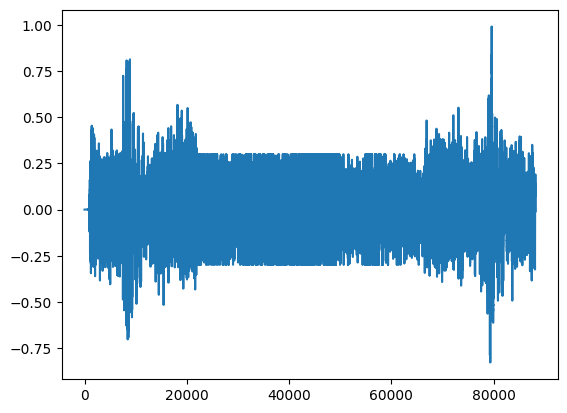

In [26]:
import matplotlib.pyplot as plt

audio_out = ev_custom.load_audio(ignore_cache=True)
# Truncate to within bounds
audio_trunc = audio_out[:round(ev_custom.sample_rate * 2.0)]

plt.plot(audio_trunc)
plt.show()

## Scene Augmentations

TODO